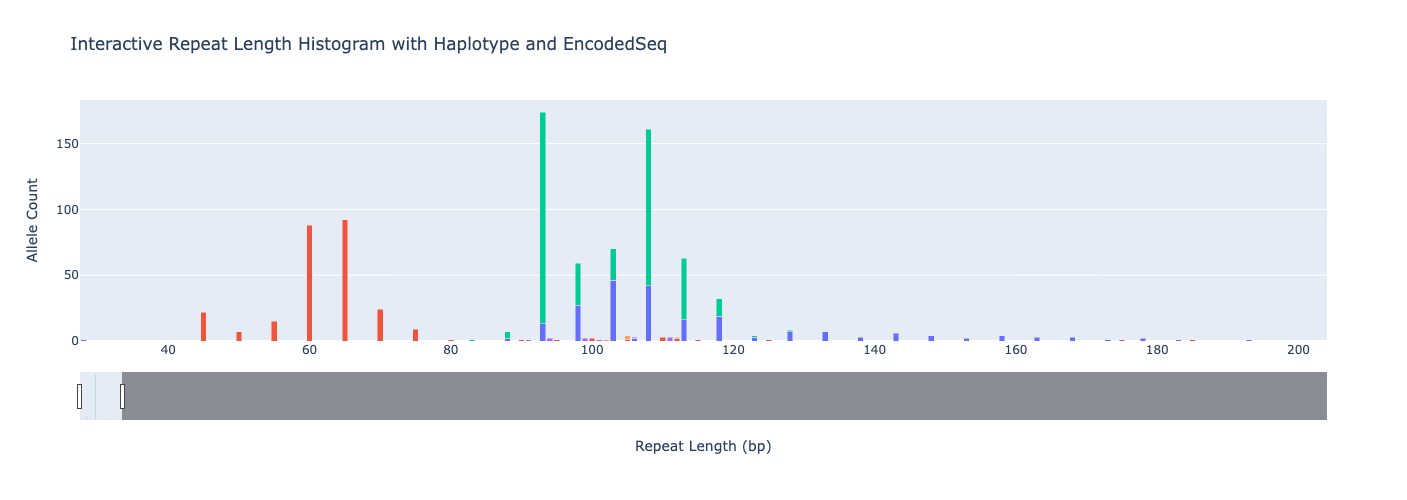

In [129]:
# import pandas as pd
# import plotly.express as px

# # Clean up
# df.loc[df['assigned_haplotype'] == '', 'assigned_haplotype'] = 'Other'
# top_haps = df['assigned_haplotype'].value_counts().head(10).index.tolist()
# df = df[df['assigned_haplotype'].isin(top_haps)]

# # Aggregate: count + preview of encodedSeqs
# agg = df.groupby(['repeatLength', 'assigned_haplotype']).agg({
#     'encodedSeq': lambda x: '<br>'.join(x.unique()[:5]),  # limit for readability
#     'assigned_haplotype': 'count'
# }).rename(columns={'assigned_haplotype': 'count'}).reset_index()

# # Plot with exact repeatLength
# fig = px.bar(
#     agg,
#     x='repeatLength',
#     y='count',
#     color='assigned_haplotype',
#     hover_data={'encodedSeq': True, 'repeatLength': True, 'count': True},
#     labels={'assigned_haplotype': 'Haplotype', 'count': 'Allele Count'},
#     title='Interactive Repeat Length Histogram with Haplotype and EncodedSeq',
# )

# fig.update_layout(
#     barmode='stack',
#     height=500,
#     width=1000,
#     xaxis=dict(
#         title='Repeat Length (bp)',
#         rangeslider=dict(visible=True),  # adds zoomable slider!
#         type='linear'
#     )
# )
# fig.update_layout(
#     legend=dict(
#         orientation="h",          # horizontal
#         yanchor="bottom",
#         y=-0.3,                   # push below plot
#         xanchor="center",
#         x=0.5,
#         title="Haplotype"
#     )
# )

# fig.show()

In [1]:
import pandas as pd
df=pd.read_csv('SAMD12_RO.csv')

In [7]:
import pandas as pd
import plotly.graph_objs as go
import ipywidgets as widgets
from ipywidgets import HBox
import numpy as np
import html  # to escape tooltip text

# Parameters
bin_width = 5

# Sanitize haplotype group
df.loc[df['assigned_haplotype'] == '', 'assigned_haplotype'] = 'Other'
top_haps = df['assigned_haplotype'].value_counts().head(10).index.tolist()
df = df[df['assigned_haplotype'].isin(top_haps)]

# Bin repeat lengths
df['repeat_bin'] = (df['repeatLength'] // bin_width) * bin_width
df['repeat_bin_center'] = df['repeat_bin'] + bin_width / 2

# Count unique encodedSeqs per bin × haplotype
seq_counts = (
    df.groupby(['repeat_bin_center', 'assigned_haplotype', 'encodedSeq'])
    .size()
    .reset_index(name='encodedSeq_count')
)

# Format tooltip text safely
def format_tooltip(group):
    return "<br>".join(
        f"{html.escape(seq)} (n={int(count)})" for seq, count in zip(group['encodedSeq'], group['encodedSeq_count'])
    )

tooltip_df = (
    seq_counts
    .groupby(['repeat_bin_center', 'assigned_haplotype'])
    .apply(format_tooltip, include_groups=False)
    .reset_index(name='encodedSeq_summary')
)

# Bar heights
bar_counts = (
    df.groupby(['repeat_bin_center', 'assigned_haplotype'])
    .size()
    .reset_index(name='count')
)

# Merge with hover text
merged = pd.merge(bar_counts, tooltip_df, on=['repeat_bin_center', 'assigned_haplotype'], how='left')

# Shorten legend labels if too long
def shorten_label(haplotype, max_len=30):
    return haplotype if len(haplotype) <= max_len else haplotype[:max_len] + "…"

merged['legend_label'] = merged['assigned_haplotype'].apply(shorten_label)

# Plot
fig = go.FigureWidget()
haplotypes = merged['assigned_haplotype'].unique()

for hap in haplotypes:
    sub = merged[merged['assigned_haplotype'] == hap]
    fig.add_bar(
        x=sub['repeat_bin_center'],
        y=sub['count'],
        name=sub['legend_label'].iloc[0],
        customdata=sub['encodedSeq_summary'],
        hovertemplate=(
            "Repeat Length Bin Center: %{x}<br>" +
            "Count: %{y}<br>" +
            "EncodedSeqs:<br>%{customdata}<extra></extra>"
        )
    )

# Layout
fig.update_layout(
    barmode='stack',
    height=600,
    width=1000,
    xaxis=dict(
        title='Repeat Length (binned, bp)',
        rangeslider=dict(visible=True),
        type='linear'
    ),
    yaxis=dict(title='Allele Count'),
    legend=dict(
        orientation="v",
        x=1.02,
        y=1,
        title="Haplotype",
        font=dict(size=10)
    )
)

# Y-slider
max_y = int(merged.groupby('repeat_bin_center')['count'].sum().max() * 1.5)

y_slider = widgets.IntRangeSlider(
    value=[0, int(max_y * 0.9)],
    min=0,
    max=max_y,
    step=10,
    description='Y-axis',
    layout=widgets.Layout(width='70px', height='600px'),
    continuous_update=False,
    orientation='vertical',
    style={'description_width': '0px'}
)

def update_y_range(range_vals):
    fig.update_yaxes(range=range_vals)

widgets.interactive(update_y_range, range_vals=y_slider)

# Display
display(HBox([fig, y_slider]))


    'data': [{'customdata': array(['&lt;TAAAA&gt;2&lt;TAA&gt;1&lt;TAAAA&gt;3 (n=…